In [ ]:
#!pip install cleverhans

In [41]:
#import tensorflow as tf
#
## Load MNIST dataset
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#
## Normalize pixel values to range [0, 1]
#x_train = x_train.astype('float32') / 255.0
#x_test = x_test.astype('float32') / 255.0
#
## Reshape input data to 4D tensor (batch_size, height, width, channels)
#x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
#x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
#
## Convert labels to categorical one-hot encoding
#y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, GlobalAveragePooling2D, Dense, Lambda
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentTensorFlowV2
from tqdm import tqdm
import os

In [38]:
from art.utils import load_mnist
# Load MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()


In [39]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)


In [77]:

def circular_padding(x, padding_size):
    # Perform circular padding on the input
    return tf.pad(x, [[0, 0], [padding_size, padding_size], [padding_size, padding_size], [0, 0]], mode='SYMMETRIC')

def simple_Conv(n_hidden, kernel_size=28, padding_size=-1):
    if padding_size == -1:
        padding_size = kernel_size // 2

    model = Sequential()
    model.add(Lambda(lambda x: circular_padding(x, padding_size), input_shape=(28, 28, 1)))
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='valid'))
    model.add(ReLU())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10))

    return model


In [41]:
n_hidden = 1000
padding_sizes = [0,2,4,6,8,10,12,14]
padding_size = padding_sizes[5]
# padding_size

In [42]:
# https://github.com/Trusted-AI/adversarial-robustness-toolbox/discussions/1288
# we use the solution from the link above

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        #SparseCategoricalCrossentropy
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [78]:
model = simple_Conv(n_hidden, kernel_size=28, padding_size=padding_size)
#model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4),
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

Tensor("Placeholder:0", shape=(None, 28, 28, 1), dtype=float32)
Tensor("lambda_3/MirrorPad:0", shape=(None, 48, 48, 1), dtype=float32)


In [45]:
#optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [46]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer,
              loss=loss_object,
              metrics=['accuracy'])
# Step 3: Create the ART classifier

classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_object,
    train_step=train_step,
    nb_classes=10,
    input_shape=(28, 28, 1),
    clip_values=(0, 1),
)

In [43]:

## Create TensorFlowV2Classifier
#model = simple_Conv(n_hidden, kernel_size=28, padding_size=padding_size)
#model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4),
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
## CategoricalCrossentropy # SparseCategoricalCrossentropy
#classifier = TensorFlowV2Classifier(
#    model=model,
#    nb_classes=10,
#    input_shape=(28, 28, 1),
#    clip_values=(0, 1),
#    train_step=train_step
#)


In [47]:


# Step 4: Train the ART classifier

classifier_history = classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3,verbose=2)
#

In [48]:
print("training done")

training done


In [49]:
## Evaluate on clean test examples
#_, accuracy = classifier.evaluate(x_test, y_test)
#print("Accuracy on clean test examples: {:.2f}%".format(accuracy * 100))
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))
# # Evaluate on clean test examples
# predictions = np.argmax(classifier.predict(x_test), axis=1)
# accuracy = np.sum(predictions == y_test) / len(y_test)
# print("Accuracy on clean test examples: {:.2f}%".format(accuracy * 100))

Accuracy on test examples: 96.0%


In [50]:
predictions = classifier.predict(x_train)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
print("Accuracy on train examples: {}%".format(accuracy * 100))

Accuracy on train examples: 95.72666666666667%


In [51]:
import numpy as np
from tqdm import tqdm
import os
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# limited example
#attack_params = [ [np.inf, [ 0.1]] ,[2, [ 1.5]]]
attack_params = [[2, [0.5, 1, 1.5, 2, 2.5]], [np.inf, [0.05, 0.1, 0.15, 0.2, 0.25]]]

In [33]:
tqdm._instances.clear()

In [36]:
#from tqdm.auto import tqdm

attack_params = [[2, [0.5, 1, 1.5, 2, 2.5]]]

for norm, epsilons in attack_params:
    for epsilon in epsilons:
        if norm == 2:
            attack = FastGradientMethod(estimator=classifier, eps=epsilon, norm=norm)
        else:
            attack = ProjectedGradientDescentTensorFlowV2(estimator=classifier, eps=epsilon, norm=norm)
        print(norm, epsilon)
        adv_correct = 0
        adv_loss = 0
        total = 0
        x_train_attack = []
        y_train_attack = []
        x_test_attack = []
        y_test_attack = []

        for x, y in tqdm(zip(x_train, y_train), total=len(y_train), desc="Generating Adversarial Examples (Train)"):
            x_np = np.array(x)  # Convert x to a NumPy array
            x_adv = attack.generate(x=np.expand_dims(x_np, axis=0))
            x_train_attack.append(x_adv[0])  # Convert EagerTensor to NumPy array
            y_train_attack.append(y)

        for x, y in tqdm(zip(x_test, y_test), total=len(y_test), desc="Generating Adversarial Examples (Test)"):
            x_np = np.array(x)  # Convert x to a NumPy array
            x_adv = attack.generate(x=np.expand_dims(x_np, axis=0))
            x_test_attack.append(x_adv[0])  # Convert EagerTensor to NumPy array
            y_test_attack.append(y)

        # Convert to numpy arrays
        x_train_attack = np.array(x_train_attack)
        y_train_attack = np.array(y_train_attack)
        x_test_attack = np.array(x_test_attack)
        y_test_attack = np.array(y_test_attack)

        # Save the adversarial data
        attack_name = attack.__class__.__name__
        model_name = "simple_Conv_28_10_1000"  # Update with the appropriate model name
        save_dir = "adversarial_data"
        os.makedirs(save_dir, exist_ok=True)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_train.npz"), x_train_attack=x_train_attack, y_train_attack=y_train_attack)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_test.npz"), x_test_attack=x_test_attack, y_test_attack=y_test_attack)

        print(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}"))

        # Calculate accuracy and loss
        for x, y in tqdm(zip(x_test_attack, y_test_attack), total=len(y_test_attack), desc="Evaluating Adversarial Examples"):
            predictions_adv = np.argmax(classifier.predict(np.expand_dims(x, axis=0)), axis=1)
            adv_correct += (predictions_adv == y).sum()
            total += 1

        _, adv_loss = classifier.model.evaluate(x_test_attack, y_test_attack, verbose=0)
        accuracy = adv_correct / total
        print("Accuracy on adversarial test examples (L_{:.0f}, eps={:.2f}): {:.2f}%. Loss: {:.2f}".format(norm, epsilon, accuracy * 100, adv_loss))

2 0.5


Generating Adversarial Examples (Test): 100%|██████████| 10000/10000 [07:59<00:00, 20.86it/s]


adversarial_data\simple_Conv_28_10_1000_FastGradientMethod_0.5


Evaluating Adversarial Examples: 100%|██████████| 10000/10000 [01:59<00:00, 84.03it/s]


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
attack_params = [[2, [0.5, 1, 1.5, 2, 2.5]], [np.inf, [0.05, 0.1, 0.15, 0.2, 0.25]]]


In [35]:
from tqdm.auto import tqdm

#attack_params = [[2, [0.5, 1, 1.5, 2, 2.5]], [np.inf, [0.05, 0.1, 0.15, 0.2, 0.25]]]

for norm, epsilons in attack_params:
    for epsilon in epsilons:
        if norm == 2:
            attack = FastGradientMethod(estimator=classifier, eps=epsilon, norm=norm)
        else:
            attack = ProjectedGradientDescentTensorFlowV2(estimator=classifier, eps=epsilon, norm=norm)
        print(norm, epsilon)
        attack_name = attack.__class__.__name__
        model_name = "simple_Conv_28_10_1000"  # Update with the appropriate model name
        adv_correct = 0
        adv_loss = 0
        total = 0
        x_train_attack = []
        y_train_attack = []
        x_test_attack = []
        y_test_attack = []
        print(f"Generating Adversarial Examples (Train) {model_name}_{attack_name}_{epsilon}")
        x_train_attack = attack.generate(x=x_train)
        y_train_attack = np.copy(y_train)

        print( f"Generating Adversarial Examples (Test) {model_name}_{attack_name}_{epsilon}")
        x_test_attack = attack.generate(x=x_test)
        y_test_attack = np.copy(y_test)

        # Convert to numpy arrays
        x_train_attack = np.array(x_train_attack)
        y_train_attack = np.array(y_train_attack)
        x_test_attack = np.array(x_test_attack)
        y_test_attack = np.array(y_test_attack)

        # Save the adversarial data

        save_dir = "adversarial_data"
        os.makedirs(save_dir, exist_ok=True)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_train.npz"), x_train_attack=x_train_attack, y_train_attack=y_train_attack)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_test.npz"), x_test_attack=x_test_attack, y_test_attack=y_test_attack)

        print(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}"))

        # Calculate accuracy and loss
        for x, y in tqdm(zip(x_test_attack, y_test_attack), total=len(y_test_attack), desc="Evaluating Adversarial Examples"):
            predictions_adv = np.argmax(classifier.predict(np.expand_dims(x, axis=0)), axis=1)
            adv_correct += (predictions_adv == y).sum()
            total += 1

        _, adv_loss = classifier.model.evaluate(x_test_attack, y_test_attack, verbose=0)
        accuracy = adv_correct / total
        print("Accuracy on adversarial test examples (L_{:.0f}, eps={:.2f}): {:.2f}%. Loss: {:.2f}".format(norm, epsilon, accuracy * 100, adv_loss))

inf 0.1
Generating Adversarial Examples (Train) simple_Conv_28_10_1000_ProjectedGradientDescentTensorFlowV2_0.1


PGD - Batches: 0it [00:00, ?it/s]

ResourceExhaustedError: {{function_node __wrapped__Conv2DBackpropFilter_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[6,441,784] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Conv2DBackpropFilter]

In [102]:
#_, adv_loss = classifier.model.evaluate(x_test_attack, y_test_attack, verbose=0)

In [73]:
attack_params = [ [np.inf, [0.05, 0.15, 0.25]]] #0.1, 0.15, 0.2,


In [74]:
x_train_ = x_train[:3000] #
y_train_ = y_train[:3000]
x_test_ = x_test[:500]
y_test_ = y_test[:500]

(array([5., 9., 5., 4., 9., 4., 3., 6., 0., 5.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

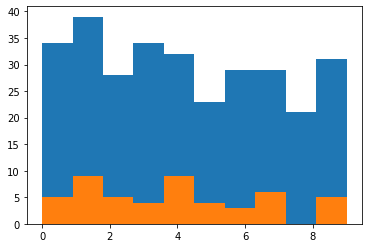

In [75]:
import matplotlib.pyplot as plt
plt.hist(np.argmax(y_train_, axis=1))
plt.hist(np.argmax(y_test_, axis=1))

In [76]:
for norm, epsilons in attack_params:
    for epsilon in epsilons:
        if norm == 2:
            attack = FastGradientMethod(estimator=classifier, eps=epsilon, norm=norm)
        else:
            attack = ProjectedGradientDescentTensorFlowV2(estimator=classifier, eps=epsilon, norm=norm)
        print(norm, epsilon)
        attack_name = attack.__class__.__name__
        model_name = "simple_Conv_28_10_1000"  # Update with the appropriate model name
        adv_correct = 0
        adv_loss = 0
        total = 0
        x_train_attack = []
        y_train_attack = []
        x_test_attack = []
        y_test_attack = []
        print(f"Generating Adversarial Examples (Train) {model_name}_{attack_name}_{epsilon}")
        x_train_attack = attack.generate(x=x_train_)
        y_train_attack = np.copy(y_train_)

        print( f"Generating Adversarial Examples (Test) {model_name}_{attack_name}_{epsilon}")
        x_test_attack = attack.generate(x=x_test_)
        y_test_attack = np.copy(y_test_)

        # Convert to numpy arrays
        x_train_attack = np.array(x_train_attack)
        y_train_attack = np.array(y_train_attack)
        x_test_attack = np.array(x_test_attack)
        y_test_attack = np.array(y_test_attack)

        # Save the adversarial data

        save_dir = "adversarial_data"
        os.makedirs(save_dir, exist_ok=True)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_train.npz"), x_train_attack=x_train_attack, y_train_attack=y_train_attack)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_test.npz"), x_test_attack=x_test_attack, y_test_attack=y_test_attack)

        print(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}"))

        # Calculate accuracy and loss
        for x, y in tqdm(zip(x_test_attack, y_test_attack), total=len(y_test_attack), desc="Evaluating Adversarial Examples"):
            predictions_adv = np.argmax(classifier.predict(np.expand_dims(x, axis=0)), axis=1)
            adv_correct += (predictions_adv == y).sum()
            total += 1

        _, adv_loss = classifier.model.evaluate(x_test_attack, y_test_attack, verbose=0)
        accuracy = adv_correct / total
        print("Accuracy on adversarial test examples (L_{:.0f}, eps={:.2f}): {:.2f}%. Loss: {:.2f}".format(norm, epsilon, accuracy * 100, adv_loss))

inf 0.05
Generating Adversarial Examples (Train) simple_Conv_28_10_1000_ProjectedGradientDescentTensorFlowV2_0.05


PGD - Batches: 0it [00:00, ?it/s]

Generating Adversarial Examples (Test) simple_Conv_28_10_1000_ProjectedGradientDescentTensorFlowV2_0.05


PGD - Batches: 0it [00:00, ?it/s]

adversarial_data\simple_Conv_28_10_1000_ProjectedGradientDescentTensorFlowV2_0.05


Evaluating Adversarial Examples: 100%|██████████| 50/50 [00:01<00:00, 32.80it/s]


Accuracy on adversarial test examples (L_inf, eps=0.05): 94.00%. Loss: 0.46
inf 0.25
Generating Adversarial Examples (Train) simple_Conv_28_10_1000_ProjectedGradientDescentTensorFlowV2_0.25


PGD - Batches: 0it [00:00, ?it/s]

Generating Adversarial Examples (Test) simple_Conv_28_10_1000_ProjectedGradientDescentTensorFlowV2_0.25


PGD - Batches: 0it [00:00, ?it/s]

adversarial_data\simple_Conv_28_10_1000_ProjectedGradientDescentTensorFlowV2_0.25


Evaluating Adversarial Examples: 100%|██████████| 50/50 [00:00<00:00, 79.87it/s]


Accuracy on adversarial test examples (L_inf, eps=0.25): 0.00%. Loss: 0.00


In [ ]:
# Smaller test
# 350 images -> 1 h 30 min - 2 epsilons